# Tweets Airline Project - Preprocessing and Modeling
***

## Contents<a id='Table of Contents'></a>

- [Imports](#Imports)
- [Load The Data](#Load_The_Data)
- [Train/Test Split](#Train_Test_Split)
- [Preprocessing](#Preprocessing)
  - [Preprocess Text](#Preprocess_Text)
  - [CountVectorize Text](#CountVectorize_Text)
  - [TfidfVectorize Text](#TfidfVectorize_Text)
  - [Create ytrain](#Create_ytrain)
- [Multinomial Naive Bayes Model](#Multinomial_Naive_Bayes_Model)
  - [With Count Vectorization](#With_Count_Vectorization)
  - [With TFIDF Vectorization](#With_TFIDF_Vectorization)
- [Logistic Regression Model](#Logistic_Regression_Model)
  - [With Count Vectorization](#With_Count_Vectorization_LR)
  - [With TFIDF Vectorization](#With_TFIDF_Vectorization_LR)
- [Predicted Error](#Predicted_Error)
- [Test Data](#Test_Data)
  - [Multinomial Naive Bayes Model](#Multinomial_Naive_Bayes_Model_TEST)
  - [Logistic Regression Model](#Logistic_Regression_Model_TEST)
  - [Confusion Matrix](#Confusion_Matrix)
- [Predictive Words](#Predictive_Words) 
  - [Method 1](#Method_1) 
  - [Method 2](#Method_2)
- [Conclusions](#Conclusions)

### Imports<a id='Imports'></a>
***

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import ConfusionMatrixDisplay
import os

from sklearn import preprocessing
from scipy.stats import chi2_contingency
import scipy.stats as ss

import warnings
warnings.filterwarnings('ignore')

### Load The Data<a id='Load_The_Data'></a>
***

In [2]:
tweets_n = pd.read_csv('../data/tweets_n.csv', index_col=0)

In [3]:
tweets_n.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_location,user_timezone,created_date,created_hour
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,NaN,Eastern Time (US & Canada),2015-02-24,11
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,NaN,Pacific Time (US & Canada),2015-02-24,11
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,LetsPlay,Central Time (US & Canada),2015-02-24,11


In [4]:
tweets_n.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14640 entries, 0 to 14639
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   name                          14640 non-null  object 
 7   retweet_count                 14640 non-null  int64  
 8   text                          14640 non-null  object 
 9   tweet_location                9893 non-null   object 
 10  user_timezone                 9820 non-null   object 
 11  created_date                  14640 non-null  object 
 12  created_hour                  14640 non-null  int64  
dtypes

### Train/Test Split<a id='Train_Test_Split'></a>

In [6]:
train, test = train_test_split(tweets_n, test_size=.2, random_state=8)

### Preprocessing<a id='Preprocessing'></a>

I created a preprocessor class to keep only English tweets,  turn text to lowercase, and remove mentions, hashtags, numbers, whitespaces, punctuations, special characters, and stopwords. Lastly, I lemmatize the text and output a completed data frame ready for modeling.


In [5]:
# %load text_preprocessor.py
import re
import string
import nltk
from langdetect import detect
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from nltk import bigrams
from nltk.util import ngrams 
from collections import Counter
from functools import reduce
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#importing our models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split

from sklearn import preprocessing


#Model Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

class TextPreprocessing():
    
    def __init__(self, dataset=None,txt=None):
        self.dataset = dataset
        self.txt = txt

    def only_English(self):
       
        self.dataset.language = self.dataset.text.apply(detect)
        self.dataset = self.dataset[self.dataset.language == 'en'] 
    
    def _remove_mentions(self,txt):
        #pattern = "@([a-zA-Z0-9_]{1,20})"
        txt = re.sub("@[A-Za-z0-9_]+","", txt) 
        return txt
        
    def remove_mentions(self):
        self.dataset.text = self.dataset.text.apply(lambda x: self._remove_mentions(x))
            
    def _remove_hashtags(self,txt):
        pattern = "#([a-zA-Z0-9_]{1,20})"
        txt = re.sub(pattern, '', txt)
        return txt
    
    def remove_hashtags(self):
        self.dataset.text = self.dataset.text.apply(lambda x: self._remove_hashtags(x))
        return self.dataset.text       

    def text_lower_case(self):
        self.dataset.text= self.dataset.text.apply(lambda x: x.lower())
        return self.dataset.text
            
    def remove_numbers(self):
        self.dataset.text = self.dataset.text.apply(lambda x: re.sub(r'\d+','', x))
        return self.dataset.text
    
    def remove_whitespaces(self):
        self.dataset.text = self.dataset.text.apply(lambda x: x.strip())
        return self.dataset.text 

    def _remove_punct(self, txt):
        txt = ''.join([char for char in txt if char not in string.punctuation])
        txt = re.sub('[0–9]','', txt)
        return txt

    def remove_punct(self):
        self.dataset.text = self.dataset.text.apply(lambda x: self._remove_punct(x))  
        return self.dataset.text
        
    def _remove_special_characters(self, txt, remove_digits=False):
        pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
        txt = re.sub(pattern, '', txt)
        return txt

    def remove_special_characters(self,remove_digits=False):
        self.dataset.text = self.dataset.text.apply(lambda x: self._remove_special_characters(x))
        return self.dataset.text
    
    def _remove_stopwords(self,txt):
        stop_words = set(stopwords.words('english'))
        stopword_list = nltk.corpus.stopwords.words('english')
        stopword_list.remove('no')
        stopword_list.remove('not')
        tokens = word_tokenize(txt)
        tokens = [token.strip() for token in tokens]
        filtered_tokens = [token for token in tokens if token not in stopword_list]
        filtered_text = ' '.join(filtered_tokens)    
        return filtered_text
    
    def remove_stopwords(self):
        self.dataset.text = self.dataset.text.apply(lambda x: self._remove_stopwords(x))
        return self.dataset.text

    def _lemmatize_text(self,txt):
        lemmatizer = WordNetLemmatizer()
        tokens_lemma = word_tokenize(txt)
        tokens_lemma = [lemmatizer.lemmatize(w, 'v') for w in tokens_lemma]
        return ' '.join(tokens_lemma)
    
    def lemmatize_text(self):
        self.dataset.text = self.dataset.text.apply(lambda x: self._lemmatize_text(x))
        return self.dataset.text       
            
    def get_dataset_text(self):
        return self.dataset.text
          
    def preprocess(self):
        self.only_English()    
        self.remove_mentions()
        self.text_lower_case()
        self.remove_numbers()
        self.remove_whitespaces()
        self.remove_punct()      
        self.remove_hashtags()
        self.remove_special_characters()
        self.remove_stopwords()
        self.lemmatize_text()
        
        return self.get_dataset_text()
 

#### Preprocess Text<a id='Preprocess_Text'></a>

In [7]:
X_train=TextPreprocessing(train).preprocess()
X_train.tail(5)

2181                    tell youre least go cover room get
10601    say friend miss flight clearly sit next plane ...
2033     tell change flight im ottawa airport ac cant f...
9556     call time redeem mile point cant get advertise...
4547                                      much ur wifi fam
Name: text, dtype: object

#### CountVectorize Text<a id='CountVectorize_Text'></a>

In [15]:

vectorizer_countvec = CountVectorizer(ngram_range = (1, 3), stop_words='english',min_df = 5)
vectorizer_countvec.fit(X_train)
Xtrain_countvec = vectorizer_countvec.transform(X_train)

Xtrain_countvec


<11546x3223 sparse matrix of type '<class 'numpy.int64'>'
	with 90567 stored elements in Compressed Sparse Row format>

#### TfidfVectorize Text<a id='TfidfVectorize_Text'></a>

In [16]:
#TF-IDF enables us to gives us a way to associate each word in a document with a number that represents how relevant each word is in that document. 

vectorizer_tfidf = TfidfVectorizer(stop_words='english', min_df=5)
vectorizer_tfidf.fit(X_train)
Xtrain_tfidf= vectorizer_tfidf.transform(X_train)
#Xtrain_tfidf_df = pd.DataFrame(Xtrain_tfidf.todense(), columns = vectorizer.get_feature_names())

Xtrain_tfidf


<11546x1894 sparse matrix of type '<class 'numpy.float64'>'
	with 74692 stored elements in Compressed Sparse Row format>

#### Create ytrain<a id='Create_ytrain'></a>

In [17]:
X_train_df = pd.DataFrame(X_train).reset_index()
X_train_df.head(3)

,index,text
0,7931,appreciate speedy response longer delay inconv...
1,715,could update suitcase please online phone trac...
2,14033,approach three hours sit plane grind dfw ameri...


In [18]:
train_resetindex = train.reset_index()
train_resetindex.head(3)

,index,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_location,user_timezone,created_date,created_hour
0,7931,568965774649520128,negative,0.3477,Late Flight,0.3477,JetBlue,ThatJasonEaton,0,@JetBlue I appreciate the speedy response. But...,NaN,NaN,2015-02-20,18
1,715,570143097809707008,negative,1.0000,Lost Luggage,1.0000,United,8629Fissile,0,@united Could you update me on the suitcase pl...,NaN,London,2015-02-24,0
2,14033,569675608969465856,negative,1.0000,Late Flight,0.6526,American,drguzman,0,@AmericanAir approaching three hours sitting i...,SpringfieldIllinois,Central Time (US & Canada),2015-02-22,17


In [19]:
# A new dataframe that match the length of the preprocessed text
train_eng = pd.merge(train_resetindex, X_train_df, how = 'right', on =['index'])
train_eng.head(3)

,index,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text_x,tweet_location,user_timezone,created_date,created_hour,text_y
0,7931,568965774649520128,negative,0.3477,Late Flight,0.3477,JetBlue,ThatJasonEaton,0,@JetBlue I appreciate the speedy response. But...,NaN,NaN,2015-02-20,18,appreciate speedy response longer delay inconv...
1,715,570143097809707008,negative,1.0000,Lost Luggage,1.0000,United,8629Fissile,0,@united Could you update me on the suitcase pl...,NaN,London,2015-02-24,0,could update suitcase please online phone trac...
2,14033,569675608969465856,negative,1.0000,Late Flight,0.6526,American,drguzman,0,@AmericanAir approaching three hours sitting i...,SpringfieldIllinois,Central Time (US & Canada),2015-02-22,17,approach three hours sit plane grind dfw ameri...


In [20]:
ytrain= train_eng.airline_sentiment
ytrain

0        negative
1        negative
2        negative
3        negative
4        negative
           ...   
11541    negative
11542    negative
11543    negative
11544    negative
11545     neutral
Name: airline_sentiment, Length: 11546, dtype: object

### Multinomial Naive Bayes Model<a id='Multinomial_Naive_Bayes_Model'></a>



Multinomial Naive Bayes and Logistic regression models are tried with count vectorization and Tfidf vectorization. GridSearchCV was used to find the best parameters and the accuracy score. 

#### With Count Vectorization<a id='With_Count_Vectorization'></a>

In [21]:
#Use GridSearch to find the best accuracy score
param_grid = {"alpha": [0.1, 1, 5, 10, 50]}
model_countvec =MultinomialNB() 
#model_countvec.get_params().keys()
grid_search = GridSearchCV(model_countvec, param_grid, cv=3, n_jobs=-1)
grid_search.fit(Xtrain_countvec, ytrain)

GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 5, 10, 50]})

In [22]:
print(grid_search.best_params_, grid_search.best_score_)

{'alpha': 1} 0.7458855672027923


In [23]:
grid_search.score(Xtrain_countvec, ytrain)

0.8038281655984757

#### With TFIDF Vectorization<a id='With_TFIDF_Vectorization'></a>

In [24]:
#Use GridSearch to find the best accuracy score
model_tfidf =MultinomialNB() 
grid_search_tfidf = GridSearchCV(model_tfidf, param_grid, cv=3, n_jobs=-1)
grid_search_tfidf.fit(Xtrain_tfidf, ytrain)

GridSearchCV(cv=3, estimator=MultinomialNB(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 5, 10, 50]})

In [25]:
print(grid_search_tfidf.best_params_, grid_search_tfidf.best_score_)

{'alpha': 0.1} 0.7383509626299961


In [26]:
grid_search_tfidf.score(Xtrain_tfidf, ytrain)

0.793694786073099

The Multinomial Naive Bayes model has the highest score of 0.803 with count vectorization.

### Logistic Regression Model<a id='Logistic_Regression_Model'></a>

#### With Count Vectorization<a id='With_Count_Vectorization_LR'></a>

In [27]:
from sklearn.linear_model import LogisticRegression
#Use GridSearch to find the best accuracy score

logreg = LogisticRegression()
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
#space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [0.01, .1, 1, 10]
logreg_gs = GridSearchCV(logreg, space, cv=5, scoring='accuracy')
logreg_gs.fit(Xtrain_countvec, ytrain)



GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [28]:
print(logreg_gs.best_params_, logreg_gs.best_score_)

{'C': 1, 'solver': 'liblinear'} 0.7698766168146852


In [29]:
logreg_gs.score(Xtrain_countvec, ytrain)

0.8632426814481206

#### With TFIDF Vectorization<a id='With_TFIDF_Vectorization_LR'></a>

In [30]:
#Use GridSearch to find the best accuracy score

logreg_tfidf = LogisticRegression()
logreg_gs_tfidf= GridSearchCV(logreg_tfidf, space, cv=5, scoring='accuracy')
logreg_gs_tfidf.fit(Xtrain_tfidf, ytrain)



GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='accuracy')

In [31]:
print(logreg_gs_tfidf.best_params_, logreg_gs_tfidf.best_score_)

{'C': 1, 'solver': 'newton-cg'} 0.7666725536625926


In [32]:
logreg_gs_tfidf.score(Xtrain_tfidf, ytrain)

0.8327559327905768

The logistic regression model showed a consistently better score with both count and Tfidf vectorization than the Multinomial Naive Bayes model. The logistic regression model with count vectorization on the training set has the highest accuracy score of 0.86.

#### Predicted Error<a id='Predicted_Error'></a>

In [36]:
#Add a column of predicted result
train_eng['predict'] = logreg_gs.best_estimator_.predict(Xtrain_countvec)
train_eng.head(3)

,index,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text_x,tweet_location,user_timezone,created_date,created_hour,text_y,predict
0,7931,568965774649520128,negative,0.3477,Late Flight,0.3477,JetBlue,ThatJasonEaton,0,@JetBlue I appreciate the speedy response. But...,NaN,NaN,2015-02-20,18,appreciate speedy response longer delay inconv...,negative
1,715,570143097809707008,negative,1.0000,Lost Luggage,1.0000,United,8629Fissile,0,@united Could you update me on the suitcase pl...,NaN,London,2015-02-24,0,could update suitcase please online phone trac...,negative
2,14033,569675608969465856,negative,1.0000,Late Flight,0.6526,American,drguzman,0,@AmericanAir approaching three hours sitting i...,SpringfieldIllinois,Central Time (US & Canada),2015-02-22,17,approach three hours sit plane grind dfw ameri...,negative


In [37]:
#Select columns
prediction_error = train_eng.loc[train_eng.airline_sentiment != train_eng.predict]


prediction_error_clean = prediction_error[['airline_sentiment', 'predict', 'text_x']]
prediction_error_clean=prediction_error_clean.rename(columns = {'text_x':'original_text'})
prediction_error_clean.head(3)

,airline_sentiment,predict,original_text
5,negative,positive,@united thnx for quick reply but don't think y...
17,neutral,negative,@united refund?
19,positive,negative,@USAirways glad to be home and that your grea...


 ### Test Data<a id='Test_Data'></a>
 ***

In [39]:
X_test=TextPreprocessing(test).preprocess()
X_test

6046                                        aww thank love
10963    im finalstretch chairman execplat mileagerun k...
758      fly unite aus austin bergstrom cancun intl bes...
12064                                                thank
12923    still cant get change flight really important ...
                               ...                        
10218    sad experience today family southwest direct m...
12328    ill stick future no change fee first bag free ...
8049     thank jetblue not jetgreen jetred blue favorit...
5627             thank help shannon great customer service
8161     yes best case scenario get gear late flight fr...
Name: text, Length: 2897, dtype: object

In [40]:
Xtest_countvec = vectorizer_countvec.transform(X_test)
Xtest_countvec

<2897x3223 sparse matrix of type '<class 'numpy.int64'>'
	with 22536 stored elements in Compressed Sparse Row format>

In [41]:
X_test_df = pd.DataFrame(X_test).reset_index()

test_resetindex = test.reset_index()
test_eng = pd.merge(test_resetindex, X_test_df, how = 'right', on =['index'])
test_eng.shape

(2897, 15)

In [42]:
ytest= test_eng.airline_sentiment
ytest

0       positive
1        neutral
2       positive
3       positive
4       negative
          ...   
2892    negative
2893    negative
2894    positive
2895    positive
2896    negative
Name: airline_sentiment, Length: 2897, dtype: object

#### Multinomial Naive Bayes Model<a id='Multinomial_Naive_Bayes_Model_TEST'></a>

In [43]:
grid_search.score(Xtest_countvec, ytest)

0.7787366240938902

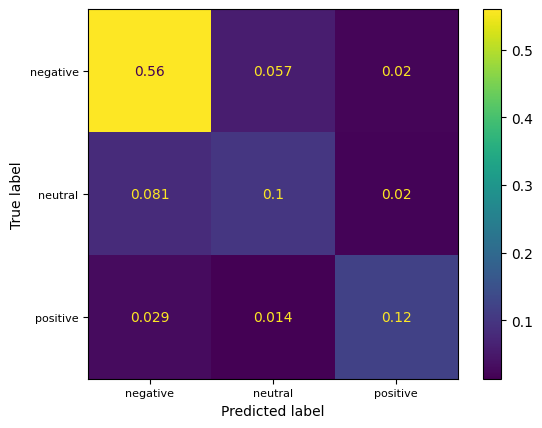

In [44]:
y_pred_test_countvec_nb = grid_search.best_estimator_.predict(Xtest_countvec)
cm_test_countvec_nb = confusion_matrix(ytest, y_pred_test_countvec_nb)
percent_cm_test_countvec_nb = cm_test_countvec_nb / cm_test_countvec_nb.sum()

_, ax = plt.subplots()
display_percent_cm_test_countvec_nb = ConfusionMatrixDisplay(confusion_matrix = percent_cm_test_countvec_nb, 
                                    display_labels = ['negative','neutral','positive'])

ax.set_xticklabels(labels = ['negative','neutral','positive'], fontsize = 8)
ax.set_yticklabels(labels = ['negative','neutral','positive'], fontsize = 8)
display_percent_cm_test_countvec_nb.plot(ax = ax)

#### Logistic Regression Model<a id='Logistic_Regression_Model_TEST'></a>

In [45]:
logreg_gs.score(Xtest_countvec, ytest)

0.7977217811529168

When it performs on the test data, the score is 0.798. It shows evidence of overfitting to the data. 

#### Confusion Matrix<a id='Confusion_Matrix'></a>

In [46]:
y_pred_test_countvec = logreg_gs.best_estimator_.predict(Xtest_countvec)
#y_pred_test_countvec = model_countvec.predict(Xtest_countvec)

#Accuracy_test_countvec = accuracy_score (ytest, y_pred_test_countvec)

#print("Accuracy on test data Countvec: {:2f}".format(Accuracy_test_countvec))

In [47]:
cm_test_countvec = confusion_matrix(ytest, y_pred_test_countvec)
percent_cm_test_countvec = cm_test_countvec / cm_test_countvec.sum()

percent_cm_test_countvec


array([[0.58094581, 0.04142216, 0.01484294],
       [0.07835692, 0.10597169, 0.01691405],
       [0.03072144, 0.02002071, 0.11080428]])

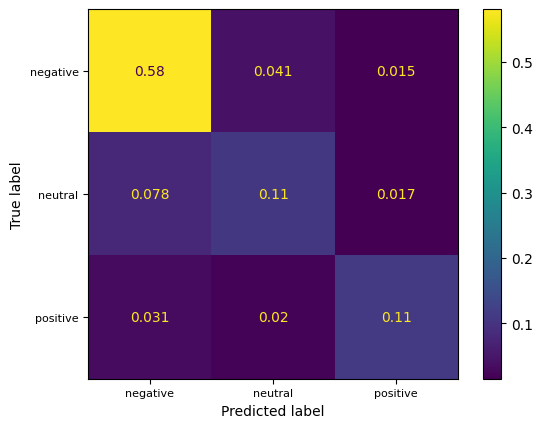

In [48]:

_, ax = plt.subplots()
display_percent_cm_test_countvec = ConfusionMatrixDisplay(confusion_matrix = percent_cm_test_countvec, 
                                    display_labels = ['negative','neutral','positive'])
                                   
#ax.set_xticks([0, 1])
#ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['negative','neutral','positive'], fontsize = 8)
ax.set_yticklabels(labels = ['negative','neutral','positive'], fontsize = 8)
display_percent_cm_test_countvec.plot(ax = ax)

### Predictive Words<a id='Predictive_Words'></a>

#### Method 1<a id='Method_1'></a>

I created a new feature called 'new target,' which comprises the 12 classes with positive and negative sentiments for each airline. Since the positive predictive words are often general positive words such as 'thanx,' 'amaze,' 'cool,' and 'love,' I only listed the negative predictive words here for analysis. Before analyzing, I opted out of the words related to the airline names, airport names, and specific cities so that the words could better reflect the reasons behind the negative sentiments. 

In [464]:
train_eng['new_target'] = train_eng['airline'] + train_eng['airline_sentiment']
train_eng.new_target.value_counts()

Unitednegative            2080
US Airwaysnegative        1785
Americannegative          1573
Southwestnegative          947
JetBluenegative            738
Unitedneutral              566
Southwestneutral           548
JetBlueneutral             519
Southwestpositive          461
Unitedpositive             411
JetBluepositive            406
Americanneutral            359
US Airwaysneutral          302
Americanpositive           264
US Airwayspositive         202
Virgin Americanegative     149
Virgin Americaneutral      125
Virgin Americapositive     113
Name: new_target, dtype: int64

In [650]:
def predictive_words(airline_name, Xdata, ydata):
    
    print(airline_name)

    model = LogisticRegression(C=1, solver='liblinear').fit(Xdata, ydata)
    class_list = model.classes_
    
    ix_negative = np.where(class_list== airline_name + "negative")[0]
    imatrix = np.eye(Xdata.shape[1])
    
    probs_neg = model.predict_proba(imatrix)[:, ix_negative]
    ind = np.argsort(list(probs_neg.flat))
    negative_words_most = words[ind[-20:]][::-1]
    negative_prob_most = probs_neg[ind[-20:]][::-1].reshape(-1).tolist()
    
    df_neg = pd.DataFrame({'negative_words_most':negative_words_most, 
                      'negative_prob_most': negative_prob_most})#, 
                     #index =['1','2','3','4','5'])
    
    ix_positive = np.where(class_list== airline_name +"positive")[0]
    probs_positive = model.predict_proba(imatrix)[:, ix_positive]
    ind_pos = np.argsort(list(probs_positive.flat))
    positive_words_most = words[ind_pos[-20:]][::-1]
    positive_prob_most = probs_positive[ind_pos[-20:]][::-1].reshape(-1).tolist()
    
      
    df_positive = pd.DataFrame({'positive_words_most':positive_words_most, 
                      'positive_prob_most': positive_prob_most})#, 
                     #index =['1','2','3','4','5'])
    #Substract positive words from the negative words
    overall_df = df_neg.merge(df_positive, right_on='positive_words_most', left_on='negative_words_most', how='left')

    print ('')
    return overall_df


In [593]:
JetBlue_predictive= predictive_words('JetBlue', Xdata=Xtrain_countvec, ydata=train_eng['new_target'])

JetBlue_predictive.iloc[[2,4,6,7,8]]


JetBlue



,negative_words_most,negative_prob_most,positive_words_most,positive_prob_most
2,mosaic,0.228301,NaN,NaN
4,fraud,0.217709,NaN,NaN
6,coffee,0.204671,NaN,NaN
7,safety,0.201502,NaN,NaN
8,tv,0.192309,NaN,NaN


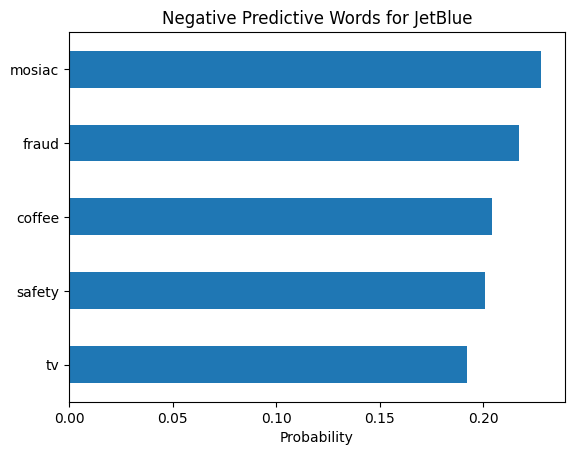

In [60]:
data = {'score':[0.192, 0.201, 0.204, 0.217, 0.228]}
negative_words = pd.DataFrame(data, index = ['tv', 'safety', 'coffee', 'fraud','mosiac'])
ax=negative_words.plot(kind='barh')  
ax.get_legend().remove()
plt.title('Negative Predictive Words for JetBlue')
plt.xlabel('Probability')
plt.show()

In [652]:
United_predictive=predictive_words('United', Xdata=Xtrain_countvec, ydata=train_eng['new_target'])

United_predictive.iloc[[3,8,11,14,15]]


United



,negative_words_most,negative_prob_most,positive_words_most,positive_prob_most
3,unfriendlyskies,0.460479,NaN,NaN
8,concourse,0.378579,NaN,NaN
11,deny,0.349503,NaN,NaN
14,delay hour,0.320638,NaN,NaN
15,lack customer,0.320487,NaN,NaN


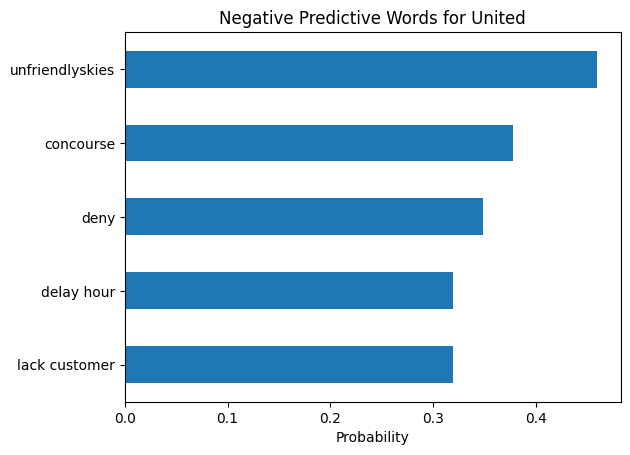

In [59]:
data = {'score':[0.320, 0.320, 0.349, 0.378, 0.460]}
negative_words = pd.DataFrame(data, index = ['lack customer', 'delay hour', 'deny', 'concourse','unfriendlyskies'])
ax=negative_words.plot(kind='barh')  
ax.get_legend().remove()
plt.title('Negative Predictive Words for United')
plt.xlabel('Probability')
plt.show()

In [686]:
Southwest_predictive = predictive_words('Southwest', Xdata=Xtrain_countvec, ydata=train_eng['new_target'])

Southwest_predictive.iloc[[2,4,7,9,11]]


Southwest



,negative_words_most,negative_prob_most,positive_words_most,positive_prob_most
2,alist,0.256821,NaN,NaN
4,wifi,0.219191,NaN,NaN
7,slow,0.210237,NaN,NaN
9,clothe,0.208702,NaN,NaN
11,rebook online,0.205550,NaN,NaN


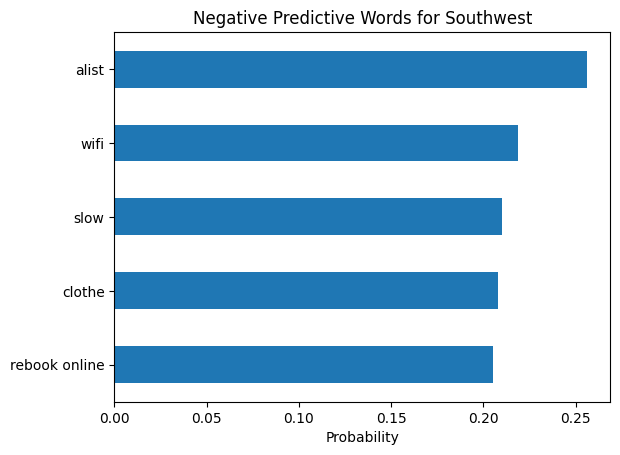

In [58]:
data = {'score':[0.205, 0.208, 0.210, 0.219, 0.256]}
negative_words = pd.DataFrame(data, index = ['rebook online', 'clothe', 'slow', 'wifi','alist'])
ax=negative_words.plot(kind='barh') 
ax.get_legend().remove()
plt.title('Negative Predictive Words for Southwest')
plt.xlabel('Probability')
plt.show()

In [731]:
American_predictive = predictive_words('American', Xdata=Xtrain_countvec, ydata=train_eng['new_target'])

American_predictive.iloc[[3,5,10,11,14]]



American



,negative_words_most,negative_prob_most,positive_words_most,positive_prob_most
3,cater,0.389793,NaN,NaN
5,old plane,0.340835,NaN,NaN
10,hang,0.283693,NaN,NaN
11,reps,0.281943,NaN,NaN
14,wait minutes,0.274959,NaN,NaN


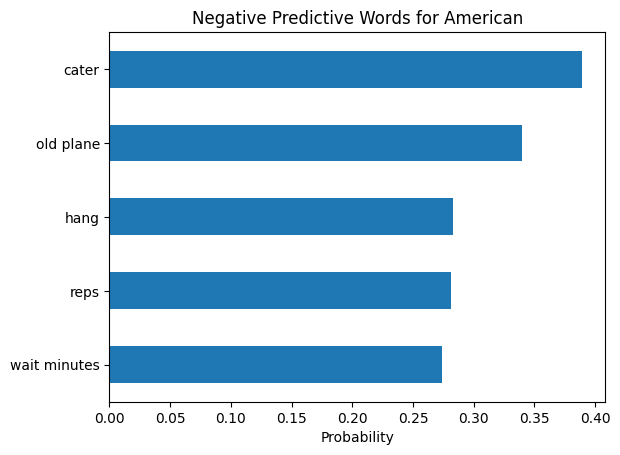

In [62]:
data = {'score':[0.274, 0.281, 0.283, 0.340, 0.389]}
negative_words = pd.DataFrame(data, index = ['wait minutes', 'reps', 'hang', 'old plane','cater'])
ax=negative_words.plot(kind='barh') 
ax.get_legend().remove()
plt.title('Negative Predictive Words for American')
plt.xlabel('Probability')
plt.show()

In [776]:
Airways_predictive=predictive_words('US Airways', Xdata=Xtrain_countvec, ydata=train_eng['new_target'])

Airways_predictive.iloc[[9,11,12,13,17]]


US Airways



,negative_words_most,negative_prob_most,positive_words_most,positive_prob_most
9,merge,0.336867,NaN,NaN
11,computer,0.324353,NaN,NaN
12,online flight,0.310840,NaN,NaN
13,ripoff,0.304397,NaN,NaN
17,doors close,0.291108,NaN,NaN


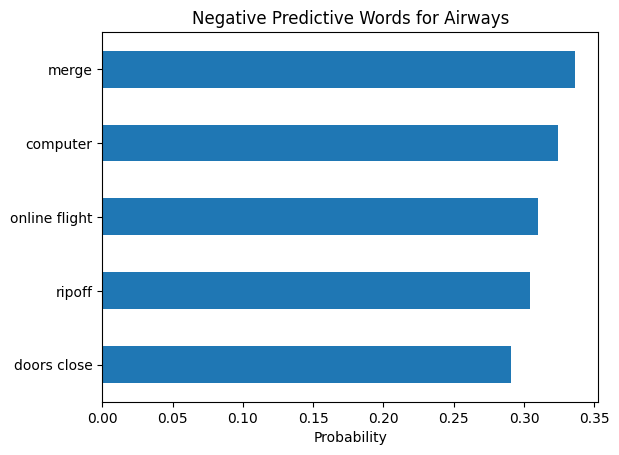

In [63]:
data = {'score':[0.291, 0.304, 0.310, 0.324, 0.336]}
negative_words = pd.DataFrame(data, index = ['doors close', 'ripoff', 'online flight', 'computer','merge'])
ax=negative_words.plot(kind='barh') 
ax.get_legend().remove()
plt.title('Negative Predictive Words for Airways')
plt.xlabel('Probability')
plt.show()

In [582]:
Virgin_predictive = predictive_words('Virgin America', Xdata=Xtrain_countvec, ydata=train_eng['new_target'])

Virgin_predictive.iloc[[0,2,4,5,7]]


Virgin America



,negative_words_most,negative_prob_most,positive_words_most,positive_prob_most
0,site,0.118625,NaN,NaN
2,checkin,0.051085,NaN,NaN
4,central,0.049865,NaN,NaN
5,iphone,0.044453,NaN,NaN
7,direct flight,0.040717,NaN,NaN


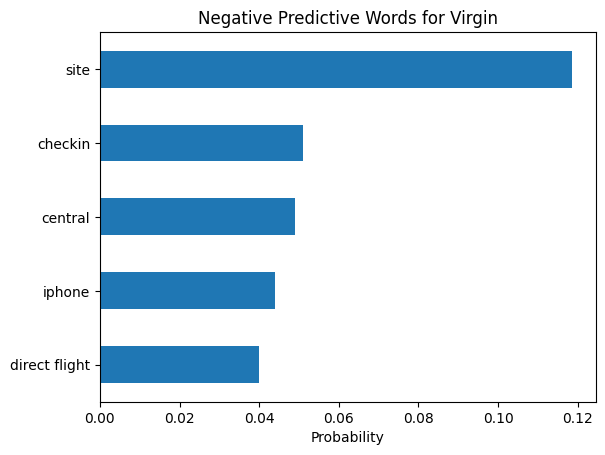

In [65]:
data = {'score':[0.040, 0.044, 0.049, 0.051, 0.1186]}
negative_words = pd.DataFrame(data, index = ['direct flight', 'iphone', 'central', 'checkin','site'])
ax=negative_words.plot(kind='barh') 
ax.get_legend().remove()
plt.title('Negative Predictive Words for Virgin')
plt.xlabel('Probability')
plt.show()

In [820]:
#Locate the index of the original tweets which contain spcific words
train_eng[train_eng.airline == 'Southwest'][train_eng[train_eng.airline == 'Southwest'].text_y.str.contains('rebook online')]


,index,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text_x,tweet_location,user_timezone,created_date,created_hour,text_y,new_target
2321,5284,569215950597201921,negative,1.0,Customer Service Issue,0.6632,Southwest,ChiefTimFitch,0,@SouthwestAir How to I rebook on-line when it ...,StLouisMissouriUSA,Central Time (US & Canada),2015-02-21,11,rebook online keep tell reserv number past dat...,Southwestnegative
2841,6666,567738715657609216,negative,1.0,Cancelled Flight,1.0000,Southwest,clements221,0,@SouthwestAir can you follow me? Flight Cancel...,NaN,NaN,2015-02-17,9,follow flight cancel flightled cant rebook onl...,Southwestnegative
4704,6724,567720082860949504,negative,1.0,Flight Booking Problems,1.0000,Southwest,portugrad,0,@SouthwestAir tried to rebook online but it sa...,ChicagolandArea,Central Time (US & Canada),2015-02-17,8,try rebook online say pay difference price ple...,Southwestnegative
5646,5235,569242798953594880,negative,1.0,Cancelled Flight,1.0000,Southwest,inspiration4ppl,0,@SouthwestAir Hi I just got a message that par...,명동서식3756638126984994,Seoul,2015-02-21,13,hi get message part flight cancel flightled ca...,Southwestnegative
9713,6736,567692504397803520,negative,1.0,Flight Booking Problems,0.6709,Southwest,kabell87,0,@SouthwestAir this is really unhelpful. Why c...,NaN,NaN,2015-02-17,6,really unhelpful cant rebook online httptconosvli,Southwestnegative
10991,6738,567688411289755648,negative,1.0,Cancelled Flight,0.6466,Southwest,kabell87,0,@SouthwestAir flight was Cancelled Flightled a...,NaN,NaN,2015-02-17,6,flight cancel flightled wont let rebook online...,Southwestnegative


In [49]:
#Find the original tweet with the index
train_eng.text_x.iloc[10991]


"@AmericanAir I've been calling your 1800 # all morning to change my name for an upcoming trip but am not able to get through. Please advise!"

#### Method 2<a id='Method_2'></a>

I separated dataset into 6 parts - 1 for each airline, then built a model to predict pos/neg for each airline, and found most predictive pos/neg words for each airline that way

In [85]:
United_train = train_eng[train_eng.airline == 'United'].text_y
ytrain_United = train_eng[train_eng.airline == 'United'].airline_sentiment

Virgin_train  = train_eng[train_eng.airline == 'Virgin America'].text_y
ytrain_Virgin = train_eng[train_eng.airline == 'Virgin America'].airline_sentiment

JetBlue_train  = train_eng[train_eng.airline == 'JetBlue'].text_y
ytrain_JetBlue = train_eng[train_eng.airline == 'JetBlue'].airline_sentiment

Southwest_train  = train_eng[train_eng.airline == 'Southwest'].text_y
ytrain_Southwest = train_eng[train_eng.airline == 'Southwest'].airline_sentiment

Airways_train  = train_eng[train_eng.airline == 'US Airways'].text_y
ytrain_Airways = train_eng[train_eng.airline == 'US Airways'].airline_sentiment

American_train  = train_eng[train_eng.airline == 'American'].text_y
ytrain_American = train_eng[train_eng.airline == 'American'].airline_sentiment

In [91]:
X_train[X_train.str.contains('hours')]

14033    approach three hours sit plane grind dfw ameri...
11744    hours late flightr flight cancel flightled get...
6542     thank reply something phone becuz drop call ho...
8200     get plane wait another hours someone read temp...
13277    tell minute wait time wait hours hour go ridic...
                               ...                        
5166                          yep two hours thirty minutes
1418     asap mean two hours worth delay return termina...
4506     quick question buy wifi phone buy tablet hours...
12955    advantage agents horrible ive wait hours call ...
10376                change flight hours crazy please help
Name: text, Length: 521, dtype: object

In [123]:
words = np.array(vectorizer_countvec.get_feature_names())

def predictive_words_lr(airline_name, Xdata, ydata):
    
    print(airline_name)

    train_countvec = vectorizer_countvec.transform(Xdata)
    model_airline = LogisticRegression(C=1, solver='liblinear').fit(train_countvec, ydata)
    airline_x = np.eye(train_countvec.shape[1])
    probs_neg = model_airline.predict_proba(airline_x)[:, 0]

    ind = np.argsort(probs_neg)
    negative_words_most = words[ind[-5:]][::-1]
    negative_prob_most = probs_neg[ind[-5:]][::-1]

    print("negative words\t     P(negative | word)")
    for w, p in zip(negative_words_most, negative_prob_most):
        print("{:>20}".format(w), "{:.2f}".format(p))


    probs_positive = model_airline.predict_proba(airline_x)[:, 2]
    ind_pos = np.argsort(probs_positive)
    positive_words_most = words[ind_pos[-5:]][::-1]
    positive_prob_most = probs_positive[ind_pos[-5:]][::-1]

    print("positive words\t     P(positive | word)")
    for w, p in zip(positive_words_most, positive_prob_most):
        #print("{:>20}".format(w), "{:.2f}".format(p))
        print("{:>20}".format(w), "{:.2f}".format(p))
    

In [124]:
predictive_words_lr('United Airline',United_train, ytrain_United)

United Airline
negative words	     P(negative | word)
               delay 0.82
               worst 0.82
                 say 0.82
              charge 0.81
                 hrs 0.78
positive words	     P(positive | word)
               thank 0.68
                thnx 0.55
           wonderful 0.54
               great 0.54
                 thx 0.51


In [125]:
predictive_words_lr('Airways Airline',Airways_train, ytrain_Airways)

Airways Airline
negative words	     P(negative | word)
               hours 0.90
               delay 0.88
                hour 0.86
                late 0.85
              answer 0.85
positive words	     P(positive | word)
               thank 0.61
             awesome 0.49
               great 0.47
                 thx 0.37
         exceptional 0.36


In [126]:
predictive_words_lr('American Airline',American_train, ytrain_American)

American Airline
negative words	     P(negative | word)
                days 0.84
                miss 0.84
             luggage 0.84
               worst 0.83
                hold 0.81
positive words	     P(positive | word)
               thank 0.71
                good 0.47
               great 0.44
                love 0.44
             awesome 0.42


In [127]:
predictive_words_lr('Southwest Airline',Southwest_train, ytrain_Southwest)

Southwest Airline
negative words	     P(negative | word)
                hold 0.73
                 bag 0.72
             luggage 0.71
               delay 0.67
               hours 0.67
positive words	     P(positive | word)
               thank 0.76
             awesome 0.71
               great 0.65
               amaze 0.64
                love 0.60


In [128]:
predictive_words_lr('JetBlue Airline',JetBlue_train, ytrain_JetBlue)

JetBlue Airline
negative words	     P(negative | word)
               delay 0.71
             respond 0.65
               hours 0.64
                hour 0.63
                 pay 0.63
positive words	     P(positive | word)
               thank 0.82
               great 0.67
                love 0.57
                 hot 0.54
                best 0.53


In [129]:
predictive_words_lr('Virgin Airline',Virgin_train, ytrain_Virgin)

Virgin Airline
negative words	     P(negative | word)
                site 0.58
               delay 0.55
                seat 0.50
                 try 0.49
             website 0.47
positive words	     P(positive | word)
               thank 0.75
                best 0.61
                love 0.58
               amaze 0.57
               great 0.57


### Conclusions<a id='Conclusions'></a>

The sentiment analysis performed in this project can help airlines improve their relationship with their customers, primarily in two ways. 

First, the predictive keywords of positive and negative sentiment that resulted from this analysis can help airlines target customer pain points to properly prioritize and allocate their resources most effectively to address the issues that will have the greatest impact. The predictive words can also be used to help airlines understand what differentiates them from other airlines, both positively and negatively. On the positive side, this can help with marketing campaigns and branding, as they'll have a better idea of how they are seen in the eyes of the customer. On the negative side, this can help point out areas in which they are lacking in regards to their competition and, therefore, where they may want to focus their efforts.

Secondly, the Logistic Regression model developed here can be used to predict positive and negative sentiment on tweets as they happen in real-time. This can be useful for airlines in order to help monitor customers' satisfaction, respond to customers' negative sentiments promptly, increase loyalty among the customer base, and build a positive brand reputation. 
